# 1. Necessary setups/imports.

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [2]:
import cv2
import pytesseract
from pytesseract import Output
import json
import numpy as np
import cv2
from scipy.integrate import odeint

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# 2. Function definition.



```
mask_text_in_image
```


This function aims to detect and mask text within an image using Optical Character Recognition (OCR) powered by the pytesseract library. It then saves the masked image and the detection details in a JSON file.

In [3]:
   # Runing  OCR using pytesseract

def mask_text_in_image(image_path, output_image_path, output_json_path, conf_threshold=60): # set confidence threshold accordingly for best results.
    #   Loading the imge
    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    if image is None:
        raise ValueError(f"Could not load image from {image_path}")


    # OEM 3: Default, and PSM 6: Assume a single uniform block of text. most of the text document consists of plain text.
    custom_config = r'--oem 3 --psm 6'
    data = pytesseract.image_to_data(image, config=custom_config, output_type=Output.DICT)

    detections = []
    n_boxes = len(data['level'])
    for i in range(n_boxes):
        # Convert confidence to integer; sometimes it is returned as a string
        try:
            conf = int(data['conf'][i])
        except ValueError:
            conf = 0

        text = data['text'][i].strip()
        # Process only if confidence is above threshold and text is not empty
        if conf > conf_threshold and text != "":
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]

            # Mask (black-out-- (0,0,0)) the detected text region
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0), thickness=-1)

            detections.append({
                "text": text,                       # force create a json dictionary.
                "confidence": conf,
                "bounding_box": {"x": x, "y": y, "w": w, "h": h}
            })

    # Save the masked image as JPG  , input image can be both png and jpg-- tested :)
    cv2.imwrite(output_image_path, image)

    # Save detection details to JSON
    output_data = {
        "masked_image": output_image_path,
        "detections": detections
    }
    with open(output_json_path, "w") as json_file:
        json.dump(output_data, json_file, indent=4)

    print(f"Masked image saved to {output_image_path}")
    print(f"Detection data saved to {output_json_path}")

# if __name__ == "__main__":
#     # Specify your file paths
#     input_image = "test_1.png"        # Path to your input image
#     masked_image = "masked_image_1.jpg"        # Output masked image path
#     output_json = "masked_image_data_1.json"   # Output JSON file path

#     mask_text_in_image(input_image, masked_image, output_json)




# 3. Use the function.


```
input_image = "path_to_input_image.jpg"
masked_image = "path_to_store_masked_image.jpg
output_json = "path_to_store_the_json.json
```



In [5]:
i= 1   # index
input_image = f"test_{i}.png"        # Path to your input image
masked_image = f"masked_image_{i}.jpg"        # Output masked image path
output_json = f"masked_image_data_{i}.json"   # Output JSON file path

mask_text_in_image(input_image, masked_image, output_json,conf_threshold=60 )


Masked image saved to masked_image_1.jpg
Detection data saved to masked_image_data_1.json


#4. Encryption code.

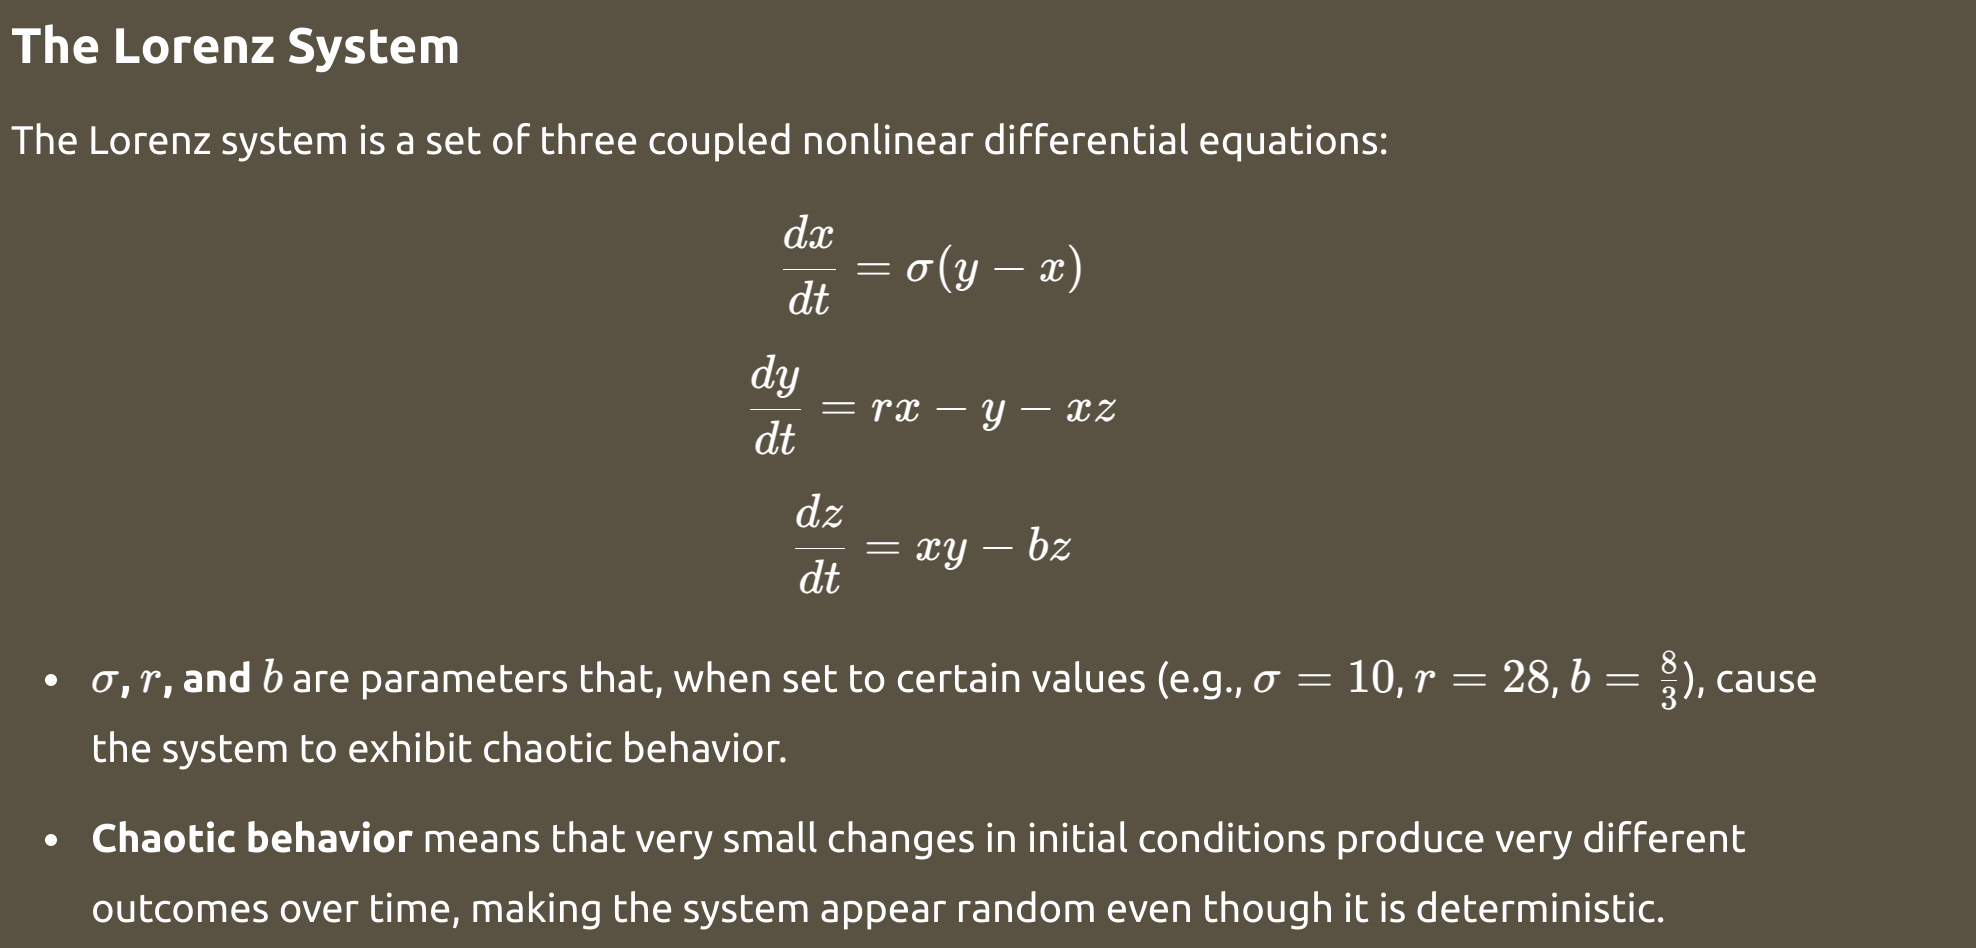

This script encrypts and decrypts specified regions of an image using chaos-based encryption, specifically the Lorenz system. It uses bounding box data from a JSON file to target the regions and displays the results for comparison.

[INFO] Maximum absolute difference: 0


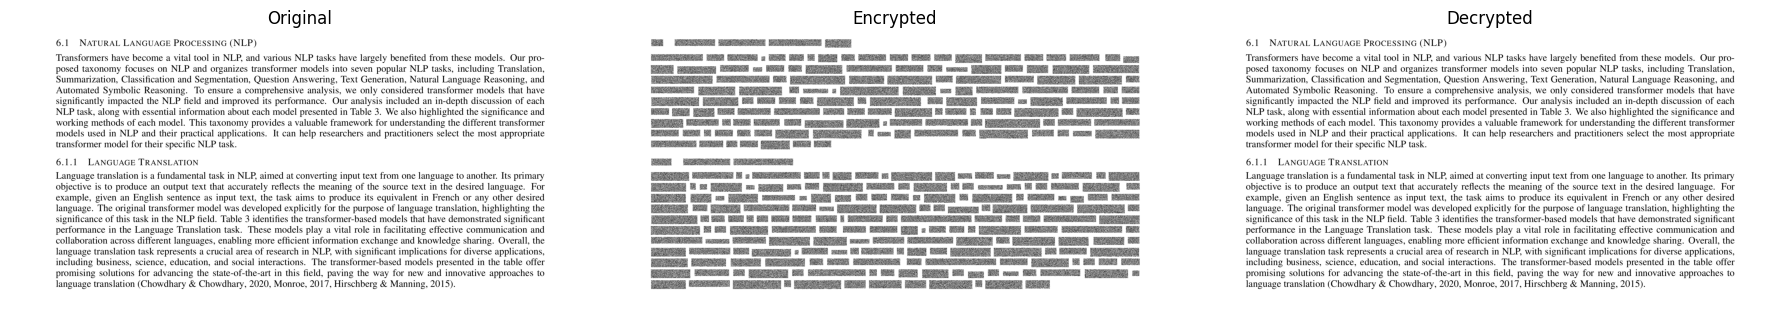

In [6]:
import cv2
import numpy as np
import json
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1) Lorenz System and Chaotic Sequence Generation ---

def lorenz(u, t, sigma=10, r=28, b=8/3):
    x, y, z = u
    return [sigma*(y - x),
            r*x - y - x*z,
            x*y - b*z]

def generate_chaotic_sequence(n_points, x0=1, y0=1, z0=1, t_max=2.0, sigma=10, r=28, b=8/3):
    t = np.linspace(0, t_max, n_points)
    u0 = [x0, y0, z0]
    sol = odeint(lorenz, u0, t, args=(sigma, r, b))
    x = sol[:, 0]
    y = sol[:, 1]
    return x, y

# --- 2) Encryption/Decryption Helpers ---

def encrypt_pixels_flat(img_flat):
    """
    Permute + XOR using Lorenz-based chaotic sequence.
    Returns cipher_flat (encrypted).
    """
    n = len(img_flat)
    x, y = generate_chaotic_sequence(n_points=n)
    xs = np.argsort(x)
    ys = np.floor((y * 1e5) % 256).astype(np.uint8)

    # Permutation step: reorder the flat pixels.
    newimg = img_flat[xs]
    # XOR step: combine with chaotic sequence.
    cipher_flat = np.bitwise_xor(newimg, ys)
    return cipher_flat

def decrypt_pixels_flat(cipher_flat):
    """
    Reverse the XOR and permutation steps to recover the original flat image.
    """
    n = len(cipher_flat)
    x, y = generate_chaotic_sequence(n_points=n)
    xs = np.argsort(x)
    ys = np.floor((y * 1e5) % 256).astype(np.uint8)

    # Reverse XOR (since XOR is its own inverse)
    newimg = np.bitwise_xor(cipher_flat, ys)

    # Invert the permutation by assigning: original[xs[i]] = newimg[i]
    plain_flat = np.empty_like(newimg)
    plain_flat[xs] = newimg
    return plain_flat

def encrypt_subimage(img, x, y, w, h):
    """
    Encrypt subregion in-place.
    Works for both grayscale and color images.
    """
    sub = img[y:y+h, x:x+w].copy()
    # For a grayscale subimage (2D) or color (3D)
    if sub.ndim == 2:
        flat_sub = sub.flatten()
        cipher_flat = encrypt_pixels_flat(flat_sub)
        cipher_sub = cipher_flat.reshape((h, w))
    else:
        cipher_sub = np.empty_like(sub)
        for c in range(sub.shape[2]):
            flat_sub = sub[:, :, c].flatten()
            cipher_flat = encrypt_pixels_flat(flat_sub)
            cipher_sub[:, :, c] = cipher_flat.reshape((h, w))
    img[y:y+h, x:x+w] = cipher_sub
    return img

def decrypt_subimage(img, x, y, w, h):
    """
    Decrypt subregion in-place.
    Works for both grayscale and color images.
    """
    sub = img[y:y+h, x:x+w].copy()
    if sub.ndim == 2:
        cipher_flat = sub.flatten()
        plain_flat = decrypt_pixels_flat(cipher_flat)
        plain_sub = plain_flat.reshape((h, w))
    else:
        plain_sub = np.empty_like(sub)
        for c in range(sub.shape[2]):
            flat_sub = sub[:, :, c].flatten()
            plain_flat = decrypt_pixels_flat(flat_sub)
            plain_sub[:, :, c] = plain_flat.reshape((h, w))
    img[y:y+h, x:x+w] = plain_sub
    return img

# --- 3) MAIN IN-MEMORY PIPELINE ---

def main():
    i = 1
    # 1. Load the original image in color mode.
    original_img = cv2.imread(f"test_{i}.png", cv2.IMREAD_COLOR)
    if original_img is None:
        raise IOError("Could not load 'test_{}.png'".format(i))

    # 2. Load bounding boxes from JSON.
    with open(f"masked_image_data_{i}.json", "r") as f:
        data = json.load(f)

    # 3. Make an in-memory copy for ENCRYPTION.
    enc_img = original_img.copy()

    # 4. Encrypt each bounding box region.
    for det in data["detections"]:
        bbox = det["bounding_box"]
        x0, y0 = bbox["x"], bbox["y"]
        w, h = bbox["w"], bbox["h"]
        # Ensure bounding box is within image dimensions.
        if (x0 + w > enc_img.shape[1]) or (y0 + h > enc_img.shape[0]):
            print(f"Warning: bounding box {bbox} is out of range.")
            continue
        encrypt_subimage(enc_img, x0, y0, w, h)

    # 5. Make an in-memory copy of the ENCRYPTED image for DECRYPTION.
    dec_img = enc_img.copy()

    # 6. Decrypt the same bounding box regions.
    for det in data["detections"]:
        bbox = det["bounding_box"]
        x0, y0 = bbox["x"], bbox["y"]
        w, h = bbox["w"], bbox["h"]
        if (x0 + w > dec_img.shape[1]) or (y0 + h > dec_img.shape[0]):
            continue
        decrypt_subimage(dec_img, x0, y0, w, h)

    # 7. Compare original and decrypted images.
    diff = cv2.absdiff(original_img, dec_img)
    print("[INFO] Maximum absolute difference:", diff.max())

    # Convert images from BGR to RGB for displaying with matplotlib.
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    enc_rgb = cv2.cvtColor(enc_img, cv2.COLOR_BGR2RGB)
    dec_rgb = cv2.cvtColor(dec_img, cv2.COLOR_BGR2RGB)

    # Plot original, encrypted, and decrypted images side-by-side.
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(original_rgb)
    axs[0].set_title("Original")
    axs[1].imshow(enc_rgb)
    axs[1].set_title("Encrypted")
    axs[2].imshow(dec_rgb)
    axs[2].set_title("Decrypted")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(f'output_images_{i}.png',dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


This script implements image encryption and decryption using the chaotic behavior of the Lorenz system. It generates chaotic sequences to permute and modify pixel values, allowing for the encryption and subsequent decryption of images.

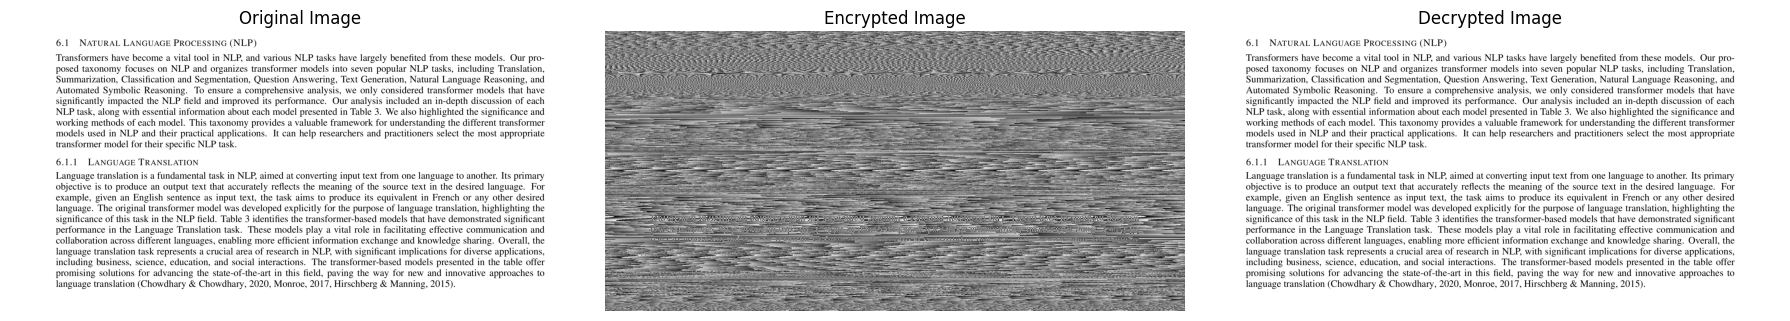

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from PIL import Image

# --- 1) Lorenz System and Chaotic Sequence Functions ---

def lorenz(u, t, sigma=10, r=28, b=8/3):
    x, y, z = u
    return [sigma*(y - x),
            r*x - y - x*z,
            x*y - b*z]

def generate_chaotic_sequence(n_points, x0=1, y0=1, z0=1, t_max=2.0, sigma=10, r=28, b=8/3):
    t = np.linspace(0, t_max, n_points)
    u0 = [x0, y0, z0]
    sol = odeint(lorenz, u0, t, args=(sigma, r, b))
    x = sol[:, 0]
    y = sol[:, 1]
    return x, y

# --- 2) Encryption Functions ---

def encrypt_pixels_flat(img_flat):
    """
    Permute + XOR using a Lorenz-based chaotic sequence.
    """
    n = len(img_flat)
    x, y = generate_chaotic_sequence(n_points=n)
    xs = np.argsort(x)
    ys = np.floor((y * 1e5) % 256).astype(np.uint8)

    # Permutation step
    newimg = img_flat[xs]
    # XOR step
    cipher_flat = np.bitwise_xor(newimg, ys)
    return cipher_flat

def encrypt_image(img):
    """
    Encrypts a full-color image by encrypting each channel independently.
    """
    encrypted_img = np.empty_like(img)
    for c in range(3):
        channel = img[:, :, c].flatten()
        cipher_channel = encrypt_pixels_flat(channel)
        encrypted_img[:, :, c] = cipher_channel.reshape(img.shape[0], img.shape[1])
    return encrypted_img

# --- 3) Decryption Functions ---

def decrypt_pixels_flat(cipher_flat):
    """
    Reverse the XOR and permutation steps to recover the original flat image.
    """
    n = len(cipher_flat)
    x, y = generate_chaotic_sequence(n_points=n)
    xs = np.argsort(x)
    ys = np.floor((y * 1e5) % 256).astype(np.uint8)

    # Reverse XOR (XOR is its own inverse)
    newimg = np.bitwise_xor(cipher_flat, ys)

    # Invert the permutation: since encryption did newimg = original[xs],
    # we reconstruct original by assigning original[xs[i]] = newimg[i]
    original = np.empty_like(newimg)
    original[xs] = newimg
    return original

def decrypt_image(img):
    """
    Decrypts a full-color image by decrypting each channel independently.
    """
    decrypted_img = np.empty_like(img)
    for c in range(3):
        channel = img[:, :, c].flatten()
        original_channel = decrypt_pixels_flat(channel)
        decrypted_img[:, :, c] = original_channel.reshape(img.shape[0], img.shape[1])
    return decrypted_img

# --- 4) Main Script ---

if __name__ == "__main__":
    # Replace with the actual path to your image file.
    i=1
    image_path = f'test_{i}.png'

    # Load the image using PIL and ensure it's in RGB mode.
    original_img = np.array(Image.open(image_path).convert("RGB"))

    # Encrypt the image.
    encrypted_img = encrypt_image(original_img)

    # Decrypt the image.
    decrypted_img = decrypt_image(encrypted_img)

    # Plot the original, encrypted, and decrypted images side by side.
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(encrypted_img)
    plt.title("Encrypted Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(decrypted_img)
    plt.title("Decrypted Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


--------------------------------------------------------------------------------MAIN CODE ENDS HERE--------------------------------------------------------------------------------